# Initial Setup

In [1]:
from datetime import datetime as dt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import statistics as stats
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (30, 15),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

# Utility Functions

In [3]:
def show_graph(data):
    plt.plot(data['Open'])
    plt.xlabel('Date')
    plt.ylabel('Open')
    plt.title('Trend of DJIA Open')
    plt.show()
    
    
def get_trend(data):
    return [data[i - 1] < data[i] for i in range(1, len(data))]

def get_moving_averages(data, window_size):
    return [stats.mean(data[i: i + window_size]) for i in range(len(data) - window_size)]

def get_moving_window_dataframes(window_size):
    averages, trends = pd.DataFrame(), pd.DataFrame()
    for column in list(djia):
        averages[column] = get_moving_averages(djia[column], window_size)
        trends[column] = get_trend(averages[column]) if column != 'Open' else averages[column][1:]
    return averages, trends

def split_to_prediction_windows(data, prediction_window, use_all_predictors):
    x = []
    y = []
    for i in range(prediction_window, len(data)):
        x.append(data[i - prediction_window: i, :] if use_all_predictors else data[i - prediction_window: i, 0])
        y.append(data[i, 0])
    x = np.array(x)
    x = x.reshape(x.shape[0], x.shape[1], 6 if use_all_predictors else 1)
    return x, np.array(y)

def inverse_transform_single_column(scaler, y_values):
    return scaler.inverse_transform(np.array([[y, 0, 0, 0, 0, 0] for y in y_values]))[:, 0]

def train_model(x_train, y_train):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='rmsprop',loss='mean_squared_error')
    history = model.fit(x_train, y_train, epochs=100, batch_size=30)
    return model, history

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_prediction(scaler, x_test, y_test, model):
    y_predict = model.predict(x_test)
    plt.plot(inverse_transform_single_column(scaler, y_test), color='blue',label='Real DJIA')
    plt.plot(inverse_transform_single_column(scaler, y_predict), color='red',label='Predicted DJIA')
    plt.title('DJIA Prediction')
    plt.xlabel('Time')
    plt.ylabel('DJIA')
    plt.legend()
    plt.show()

# Data Cleaning

In [4]:
djia = pd.read_csv('djia.csv', index_col='Date', parse_dates=['Date'], date_parser=lambda date: dt.strptime(date,'%d/%m/%Y').date())

In [5]:
djia.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


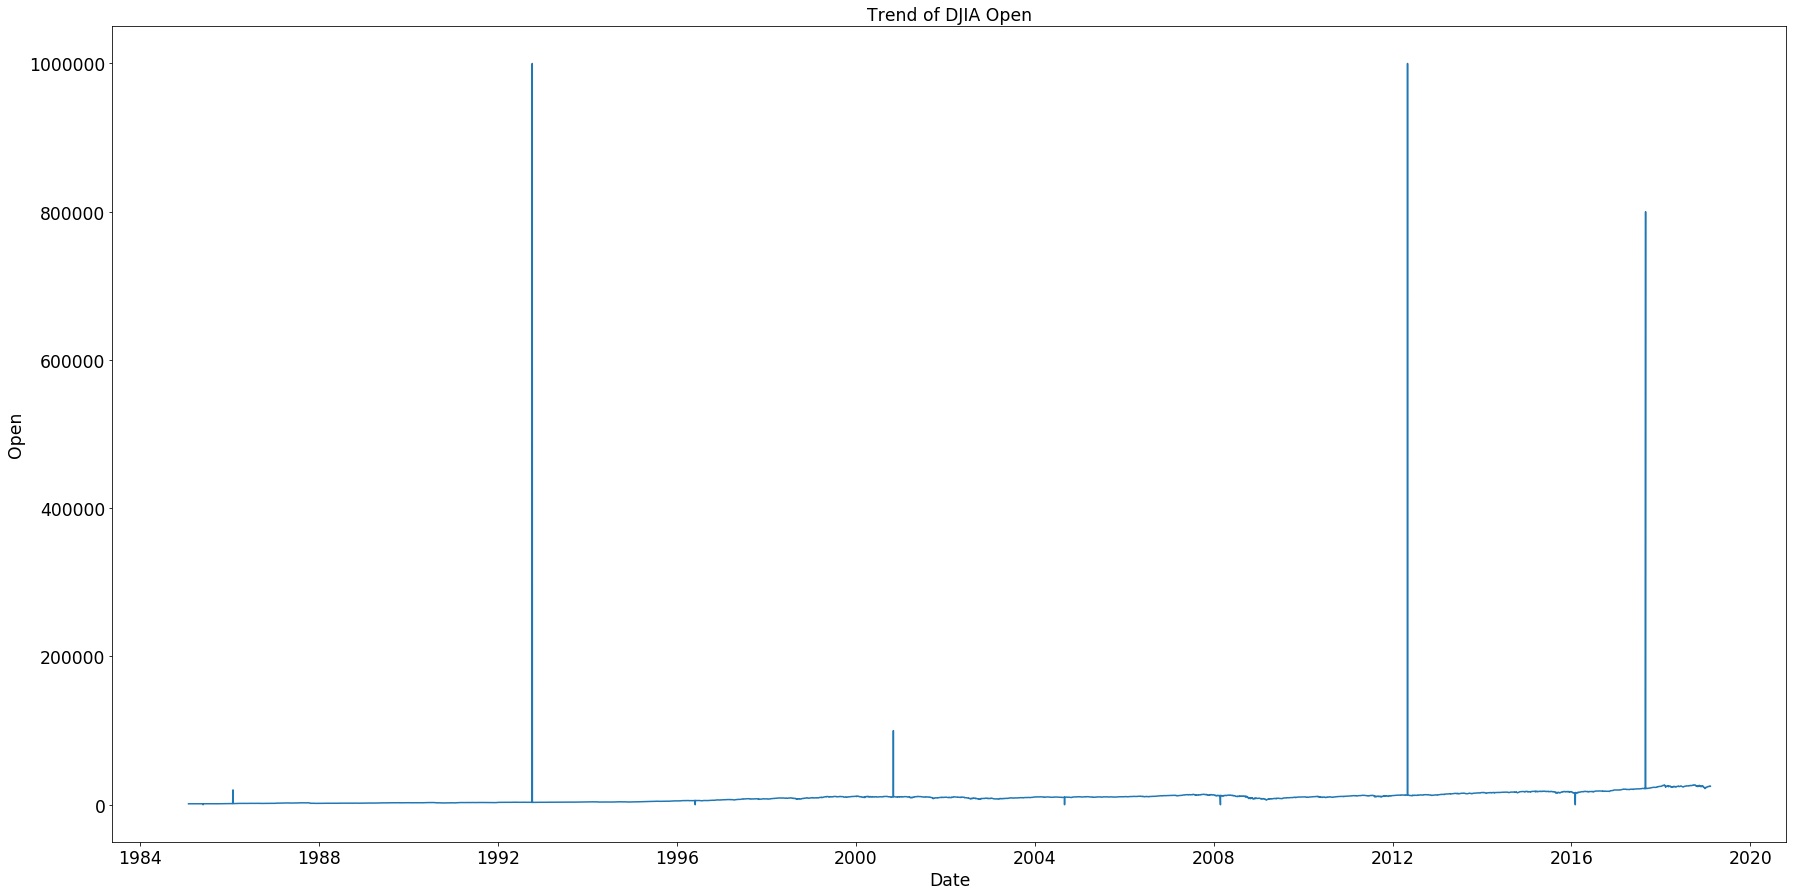

In [6]:
show_graph(djia)

In [7]:
# remove outliers and bad data
djia = djia[(djia['Open'] < 60000) & (djia['Open'] > 0) & (djia['High'] > djia['Low'])]

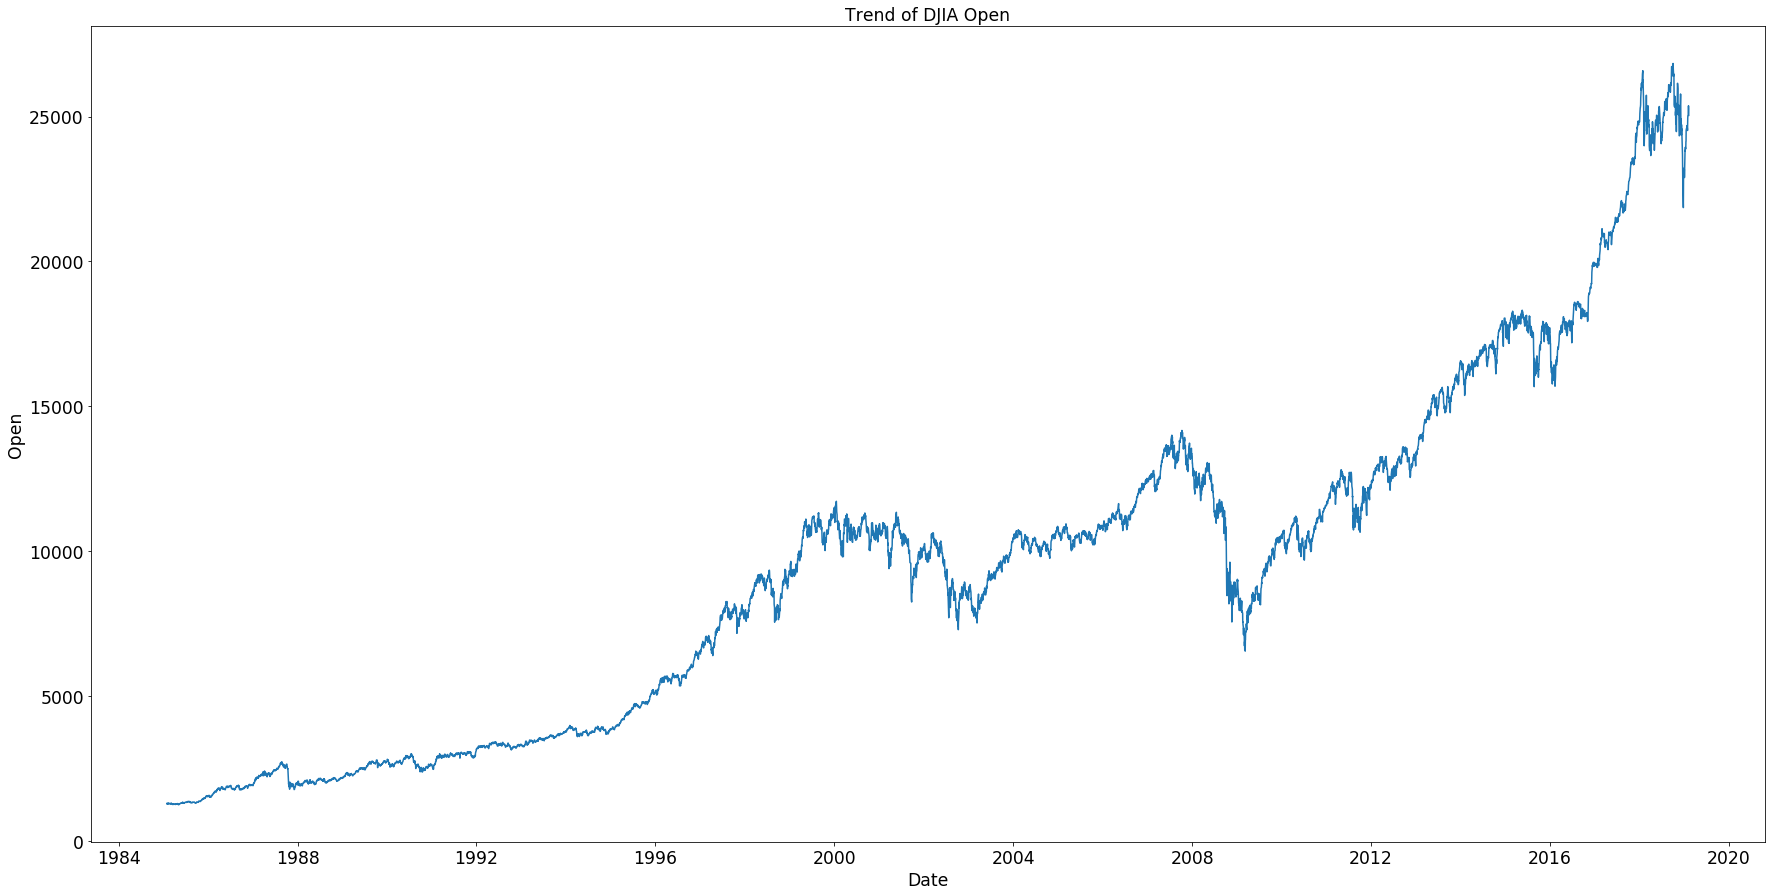

In [8]:
show_graph(djia)

In [9]:
averages, trends = get_moving_window_dataframes(3)

In [10]:
averages.head()

,Open,High,Low,Close,Adj Close,Volume
0,1286.109985,1297.996663,1272.820028,1289.090007,1289.090007,1.481667e+07
1,1285.849975,1294.869995,1273.780030,1284.123332,1284.123332,1.395667e+07
2,1277.419962,1291.483317,1270.466675,1284.856649,1284.856649,1.222667e+07
3,1281.026652,1294.059977,1272.453329,1284.343302,1284.343302,1.213667e+07
4,1283.676677,1296.856649,1274.219971,1285.299967,1285.299967,1.334667e+07


In [11]:
trends.head()

,Open,High,Low,Close,Adj Close,Volume
1,1285.849975,False,True,False,False,False
2,1277.419962,False,False,True,True,False
3,1281.026652,True,True,False,False,False
4,1283.676677,True,True,True,True,True
5,1287.983358,True,True,False,False,False


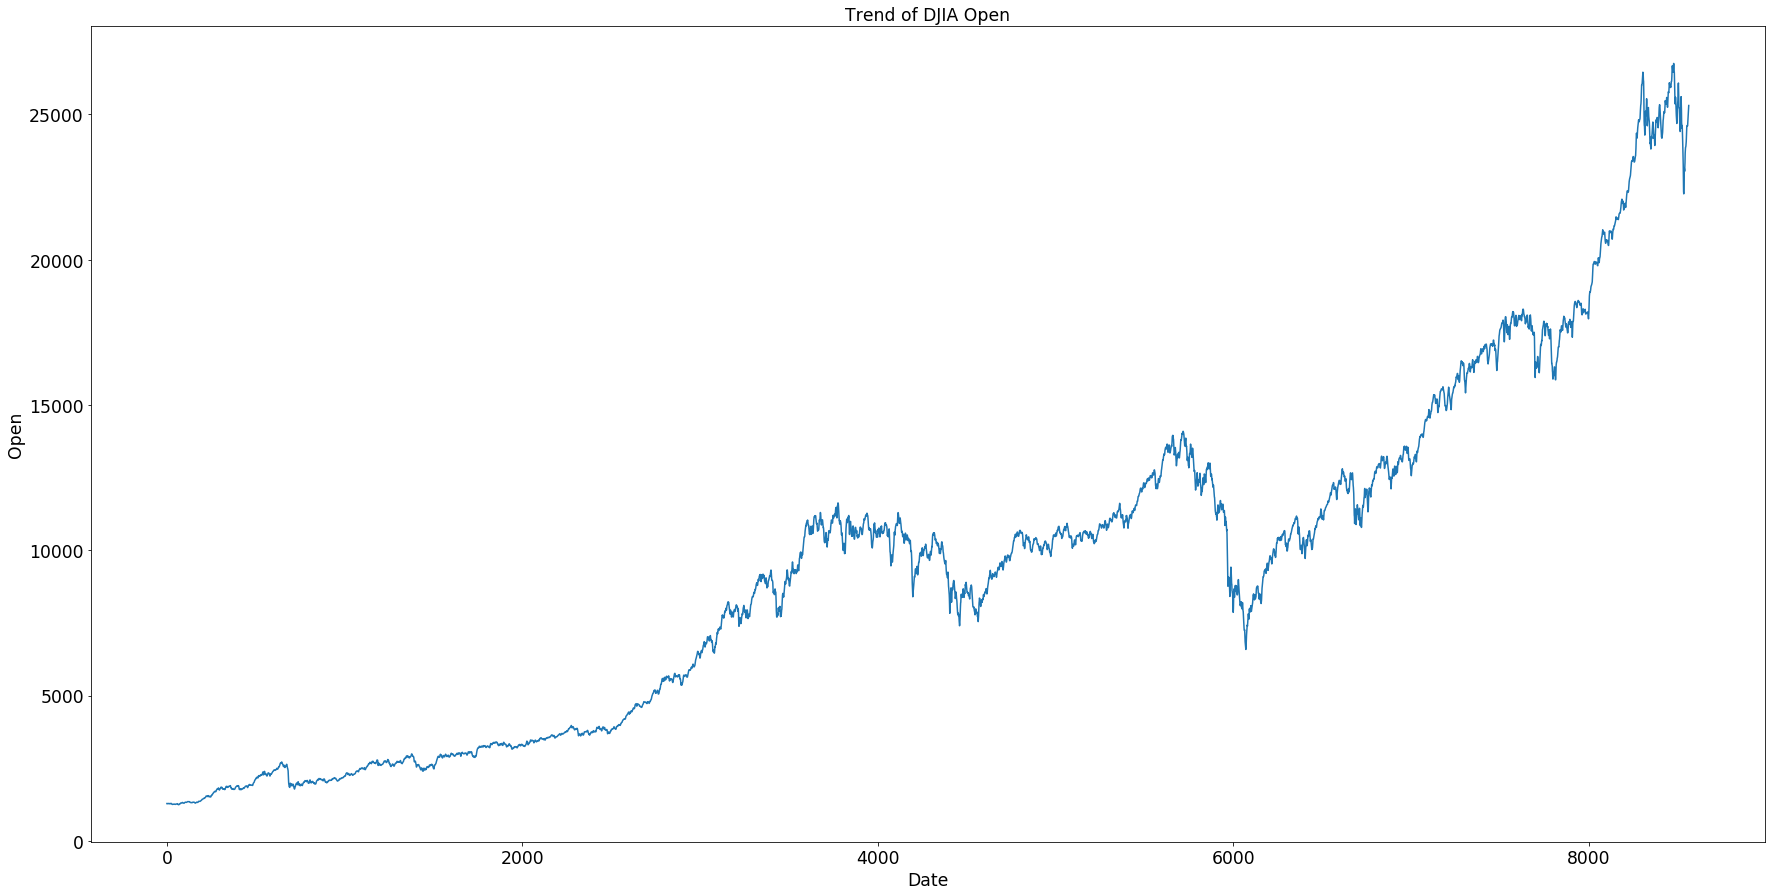

In [12]:
show_graph(averages)

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
djia_matrix = scaler.fit_transform(averages[-1000:])
djia_matrix_train = djia_matrix[:700]
djia_matrix_test = djia_matrix[700:]

# Trend Predictors Model

In [14]:
trend_scaler = MinMaxScaler(feature_range=(0,1))
trends = trends[-1000:]
trends[['Open']] = trend_scaler.fit_transform(trends[['Open']])
djia_trends = trends.values
djia_trends_train = djia_trends[:700]
djia_trends_test = djia_trends[700:]

In [15]:
x_train, y_train = split_to_prediction_windows(djia_trends_train, 50, True)
x_test, y_test = split_to_prediction_windows(djia_trends_test, 50, True)
model_trend_predictors, history_trend_predictors = train_model(x_train, y_train)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
650/650 [==============================] - 4s 7ms/step - loss: 0.0323
Epoch 2/100
650/650 [==============================] - 2s 4ms/step - loss: 0.0111
Epoch 3/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0091
Epoch 4/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0066
Epoch 5/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0069
Epoch 6/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0049
Epoch 7/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0053
Epoch 8/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0054
Epoch 9/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0039
Epoch 10/100
650/650 [=====

650/650 [==============================] - 2s 3ms/step - loss: 9.2161e-04
Epoch 89/100
650/650 [==============================] - 2s 3ms/step - loss: 9.7628e-04
Epoch 90/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 91/100
650/650 [==============================] - 2s 3ms/step - loss: 7.0393e-04
Epoch 92/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0010
Epoch 93/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 94/100
650/650 [==============================] - 2s 3ms/step - loss: 8.2994e-04
Epoch 95/100
650/650 [==============================] - 2s 3ms/step - loss: 9.9071e-04
Epoch 96/100
650/650 [==============================] - 2s 3ms/step - loss: 7.9322e-04
Epoch 97/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0011
Epoch 98/100
650/650 [==============================] - 2s 3ms/step - loss: 9.5274e-04
Epoch 99/100
650/650 [==============================] - 2s 3ms/step - lo

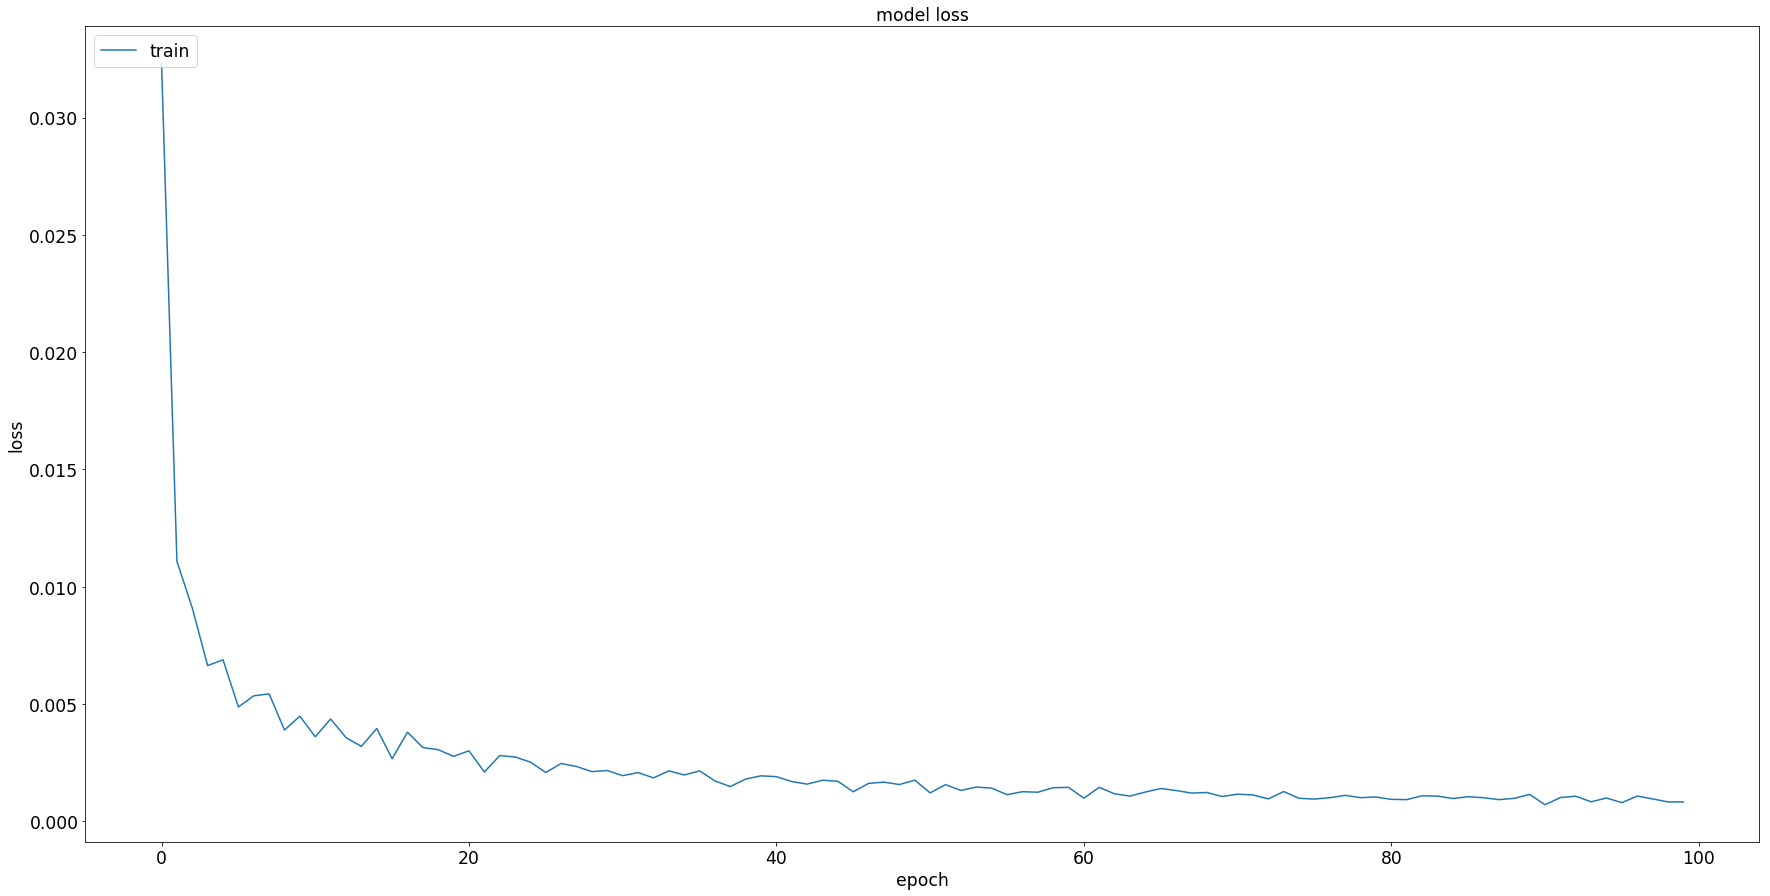

In [16]:
plot_loss(history_trend_predictors)

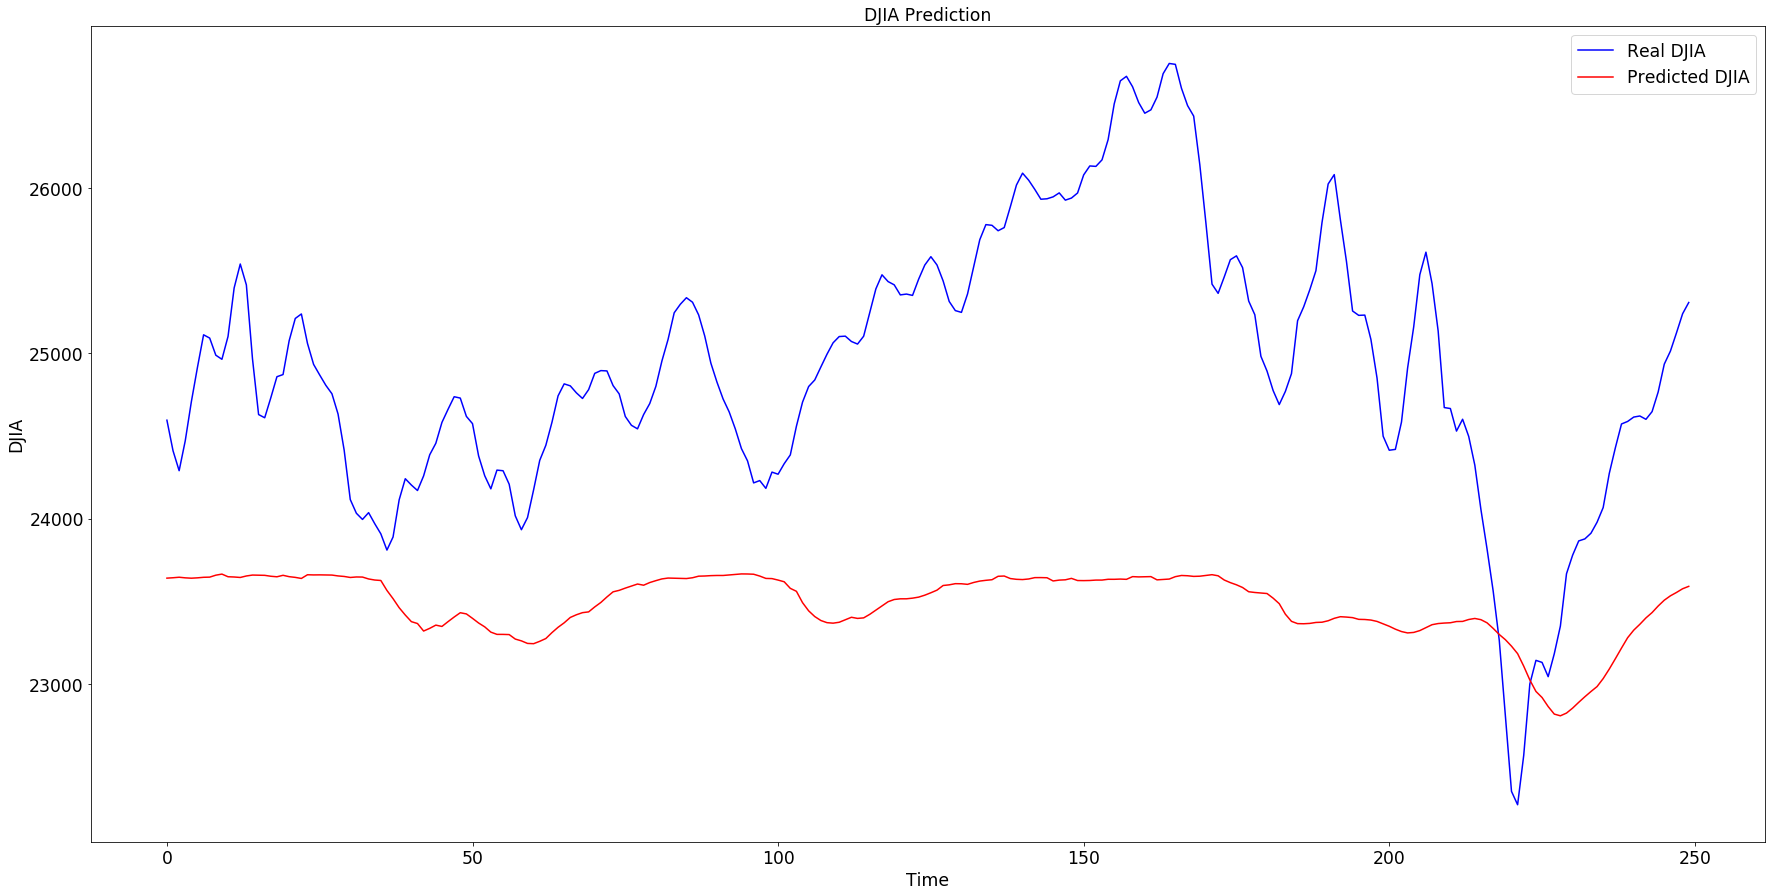

In [17]:
plot_prediction(trend_scaler, x_test, y_test, model_trend_predictors)

# All Predictors Model

In [18]:
x_train, y_train = split_to_prediction_windows(djia_matrix_train, 50, True)
x_test, y_test = split_to_prediction_windows(djia_matrix_test, 50, True)
model_all_predictors, history_all_predictors = train_model(x_train, y_train)

Epoch 1/100
650/650 [==============================] - 5s 7ms/step - loss: 0.0165
Epoch 2/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0066
Epoch 3/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0048
Epoch 4/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0045
Epoch 5/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0041
Epoch 6/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0046
Epoch 7/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0040
Epoch 8/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0035
Epoch 9/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0034
Epoch 10/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0030
Epoch 11/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0032
Epoch 12/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0032
Epoch 13/100


650/650 [==============================] - 2s 3ms/step - loss: 8.0286e-04
Epoch 98/100
650/650 [==============================] - 2s 3ms/step - loss: 7.1855e-04
Epoch 99/100
650/650 [==============================] - 2s 3ms/step - loss: 6.5143e-04
Epoch 100/100
650/650 [==============================] - 2s 3ms/step - loss: 6.1168e-04


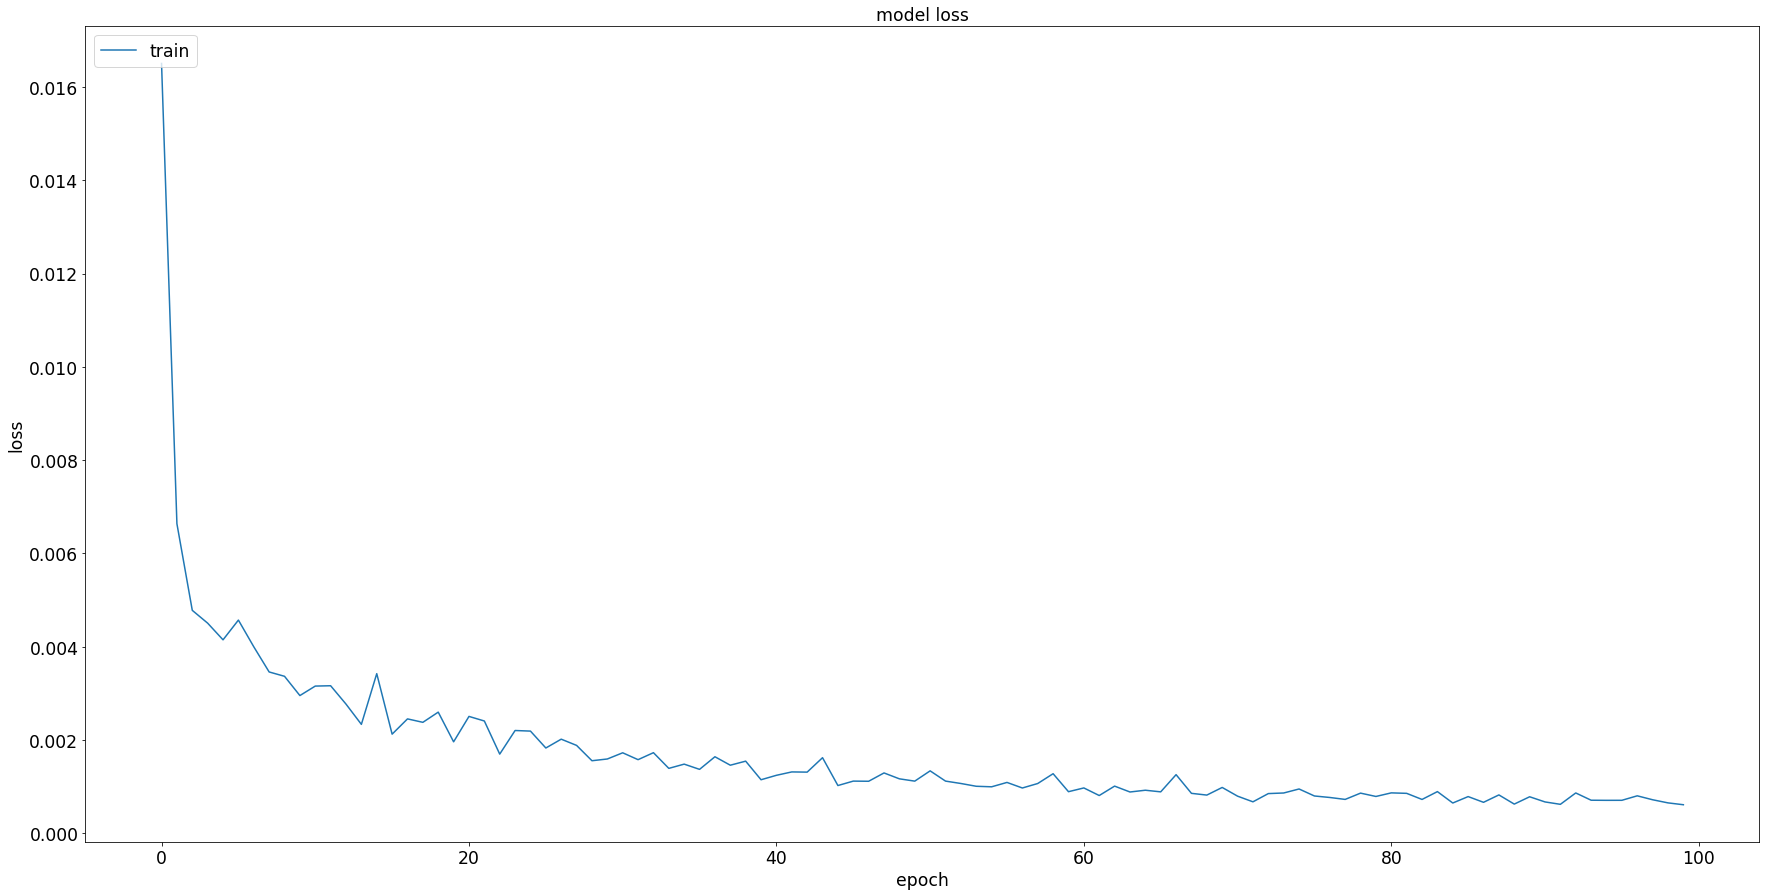

In [19]:
plot_loss(history_all_predictors)

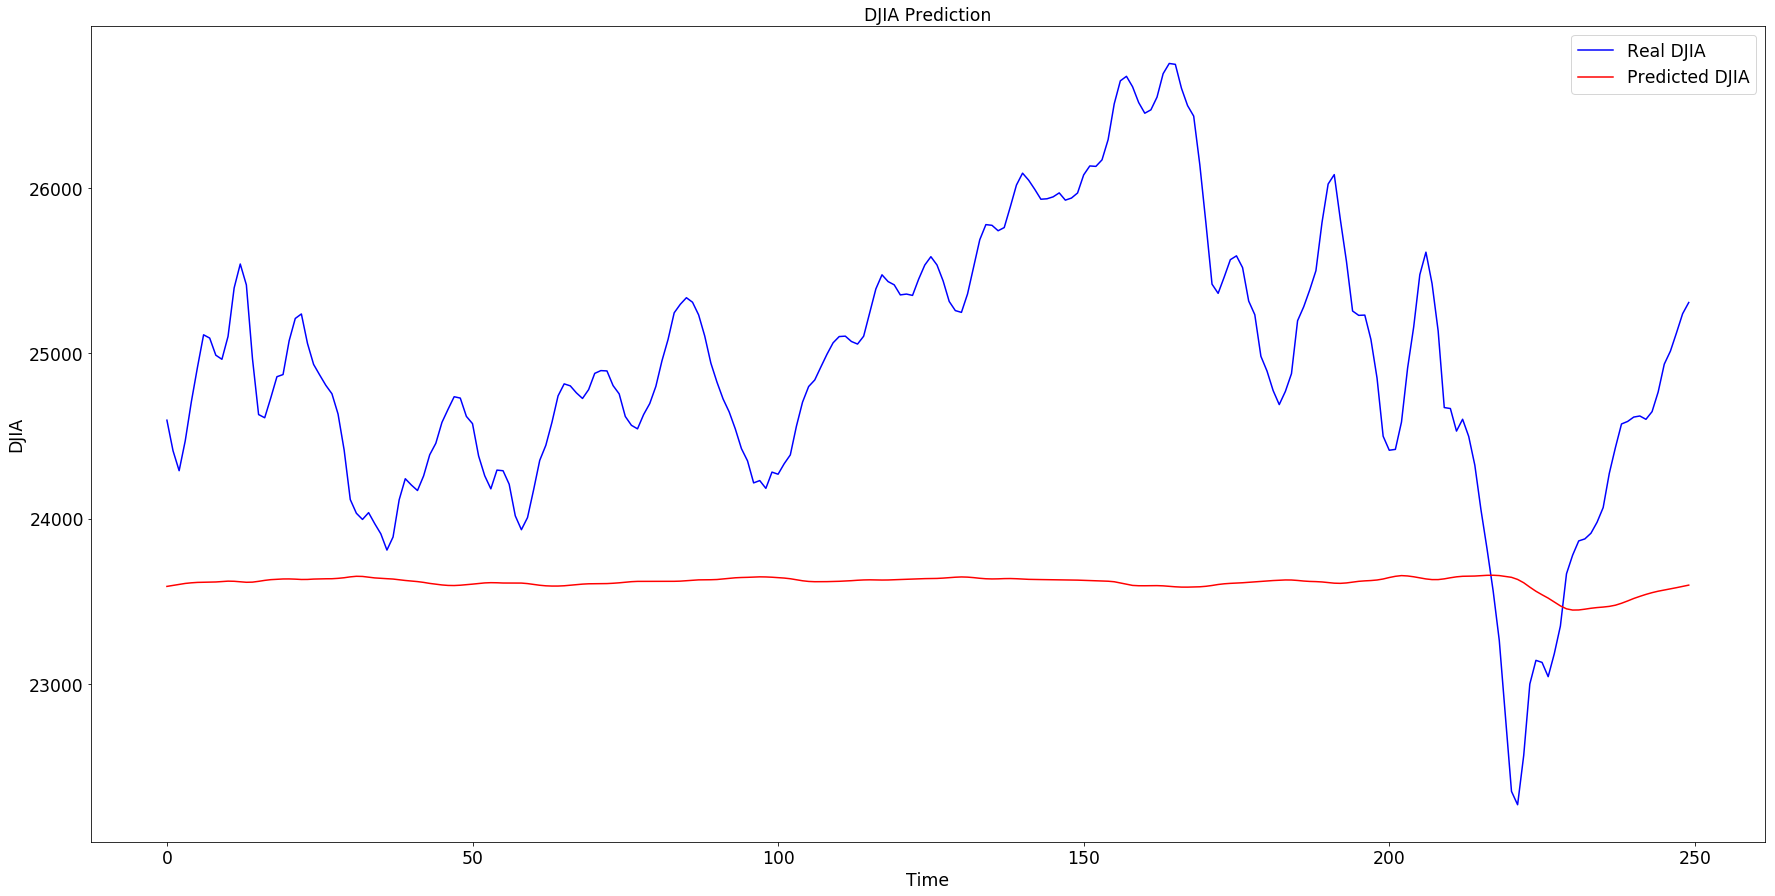

In [20]:
plot_prediction(scaler, x_test, y_test, model_all_predictors)

# Open Predictor Model

In [21]:
x_train, y_train = split_to_prediction_windows(djia_matrix_train, 50, False)
x_test, y_test = split_to_prediction_windows(djia_matrix_test, 50, False)
model, history = train_model(x_train, y_train)

Epoch 1/100
650/650 [==============================] - 5s 8ms/step - loss: 0.0219
Epoch 2/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0063
Epoch 3/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0072
Epoch 4/100
650/650 [==============================] - 2s 4ms/step - loss: 0.0057
Epoch 5/100
650/650 [==============================] - 2s 4ms/step - loss: 0.0046
Epoch 6/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0037
Epoch 7/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0049
Epoch 8/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0041
Epoch 9/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0035
Epoch 10/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0037
Epoch 11/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0028
Epoch 12/100
650/650 [==============================] - 2s 3ms/step - loss: 0.0032
Epoch 13/100


650/650 [==============================] - 2s 3ms/step - loss: 8.9645e-04
Epoch 99/100
650/650 [==============================] - 2s 3ms/step - loss: 8.4534e-04
Epoch 100/100
650/650 [==============================] - 2s 3ms/step - loss: 8.2990e-04


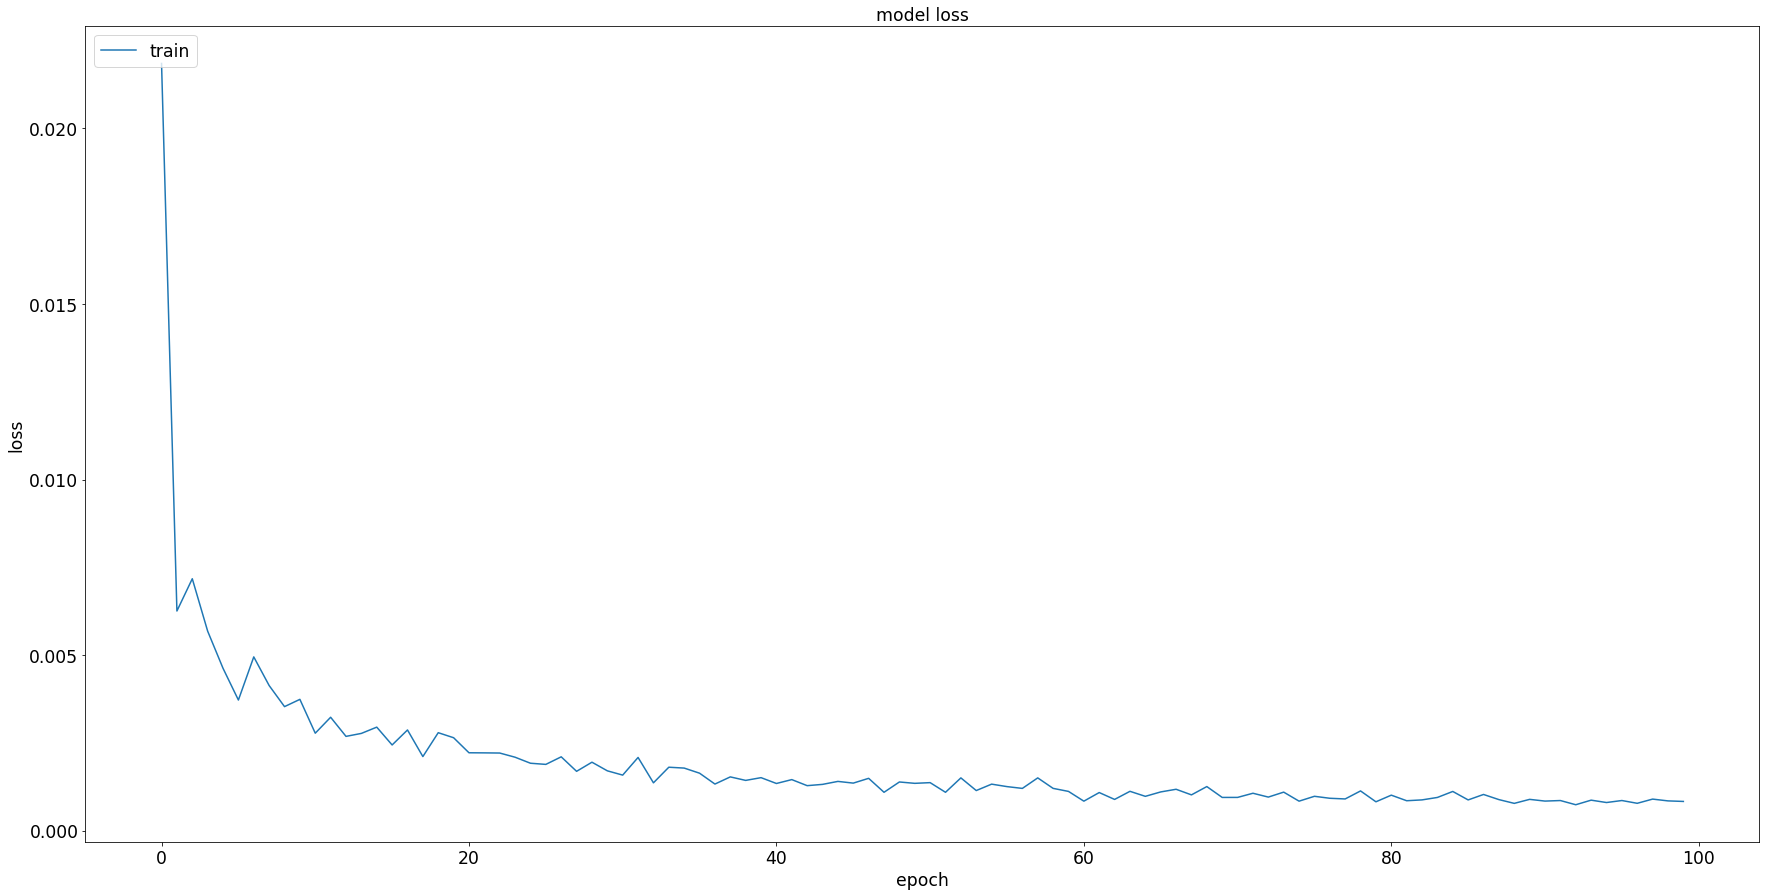

In [22]:
plot_loss(history)

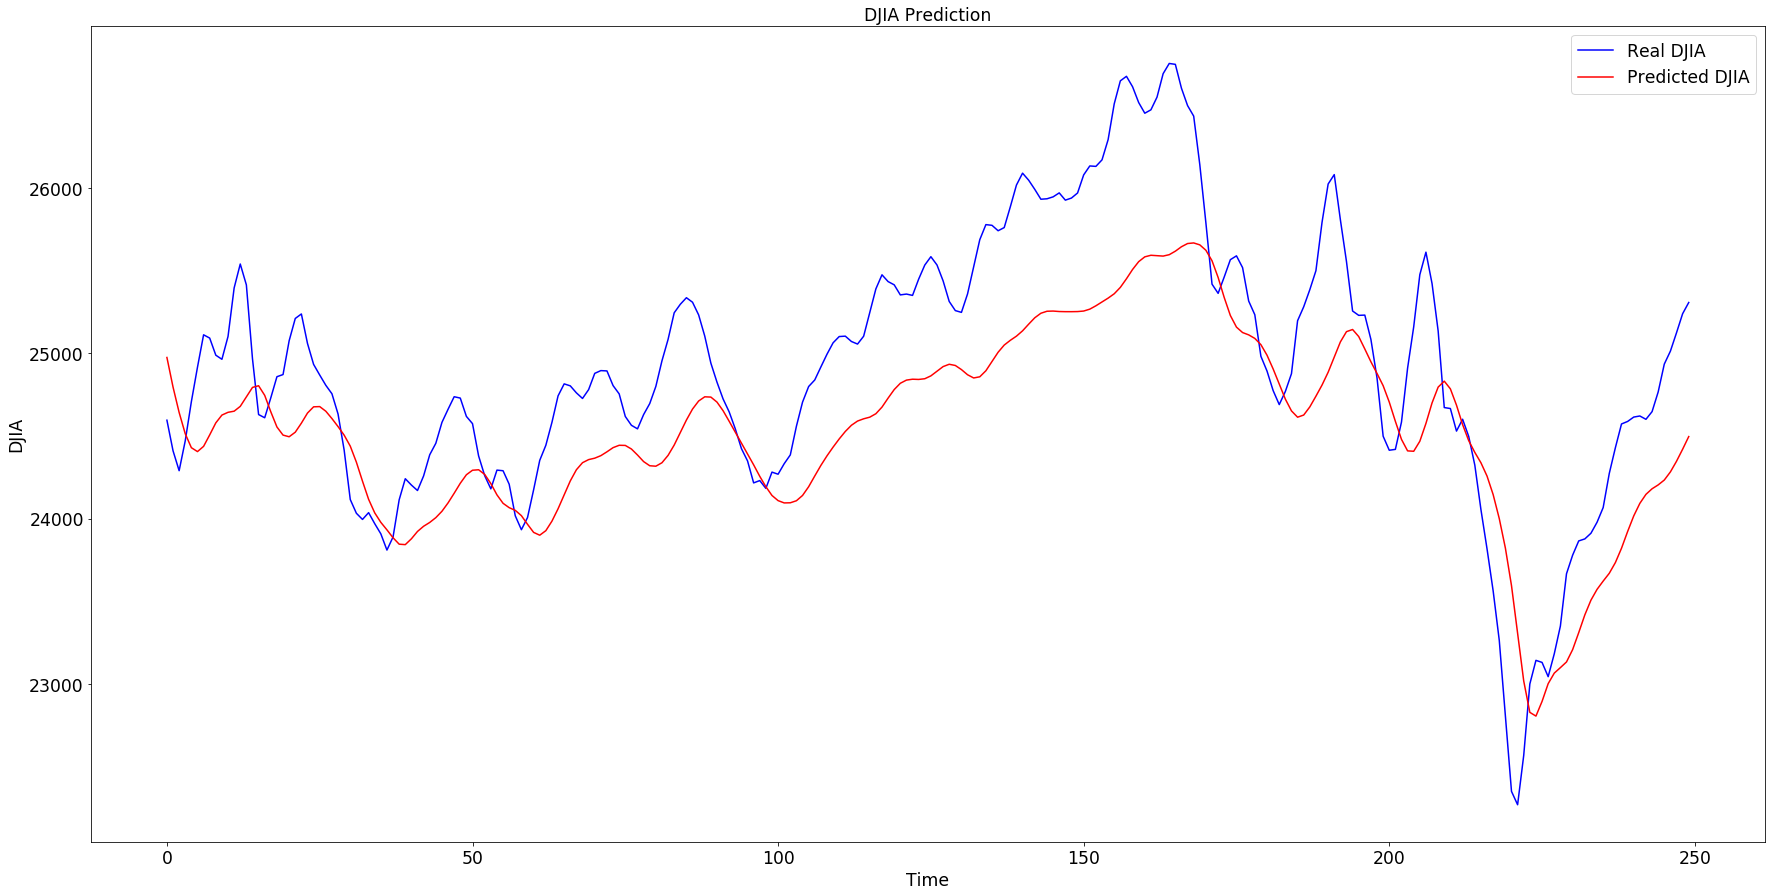

In [23]:
plot_prediction(scaler, x_test, y_test, model)